In [1]:
import numpy as np
import os
import tensorflow as tf
import cv2
import json

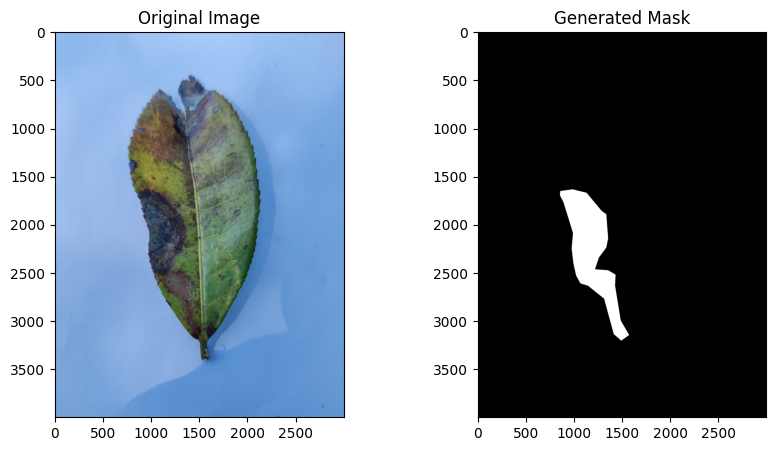

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 128, 128, 256)  │              0 │ conv2d_5[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128, 384)  │              0 │ up_sampling2d[0][0],   │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 128, 128, 128)  │        442,496 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_1           │ (None, 256, 256, 128)  │              0 │ conv2d_7[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 192)  │              0 │ up_sampling2d_1[0][0], │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 256, 256, 64)   │        110,656 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate

# Directories
json_dir = "/kaggle/input/temp-dataset/Brown_blight"
image_dir = "/kaggle/input/tea-images/Tea Images/Brown_blight"
mask_dir = "./masks"  # Directory to save generated masks

os.makedirs(mask_dir, exist_ok=True)

# Function to create mask from JSON annotation
def create_mask(json_path, image_shape):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    
    for shape in data['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)
    
    return mask

# Load and process images
json_list = os.listdir(json_dir)

train_images, valid_images, test_images = [], [], []
train_masks, valid_masks, test_masks = [], [], []

for i in range(len(json_list)):
    image_path = os.path.join(image_dir, f'Training_img_{i+1}.jpg')
    json_path = os.path.join(json_dir, f'Training_img_{i+1}.json')
    
    image = cv2.imread(image_path)
    if image is None:
        continue
    
    mask = create_mask(json_path, image.shape)
    
    # Save mask
    #mask_path = os.path.join(mask_dir, f'mask_{i+1}.png')
    #cv2.imwrite(mask_path, mask)
    
    if i < 50:
        train_images.append(image)
        train_masks.append(mask)
    elif i < 61:
        valid_images.append(image)
        valid_masks.append(mask)
    else:
        test_images.append(image)
        test_masks.append(mask)

# Display example
sample_image = train_images[0]
sample_mask = train_masks[0]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Generated Mask")
plt.show()

# Simple U-Net model for segmentation
def build_unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

unet_model = build_unet()
unet_model.summary()


In [3]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

# Preprocess images and masks
image_size = (256, 256)

def preprocess_data(images, masks):
    images_resized = [cv2.resize(img, image_size) for img in images]
    masks_resized = [cv2.resize(mask, image_size) for mask in masks]
    
    images_array = np.array(images_resized) / 255.0
    masks_array = np.array(masks_resized) / 255.0
    
    images_array = images_array.astype(np.float32)
    masks_array = masks_array.astype(np.float32)
    
    masks_array = np.expand_dims(masks_array, axis=-1)  # Ensure correct shape
    
    return images_array, masks_array

# Prepare datasets
X_train, y_train = preprocess_data(train_images, train_masks)
X_valid, y_valid = preprocess_data(valid_images, valid_masks)
X_test, y_test = preprocess_data(test_images, test_masks)

# Callbacks
checkpoint = ModelCheckpoint("unet_best_model.keras", monitor="val_loss", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True)

# Train the model
history = unet_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate on test set
test_loss, test_accuracy = unet_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6216 - loss: 0.4420   
Epoch 1: val_loss improved from inf to 0.08761, saving model to unet_best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 5s/step - accuracy: 0.6461 - loss: 0.4236 - val_accuracy: 0.9696 - val_loss: 0.0876
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9666 - loss: 0.1042
Epoch 2: val_loss improved from 0.08761 to 0.07433, saving model to unet_best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 290ms/step - accuracy: 0.9664 - loss: 0.1045 - val_accuracy: 0.9696 - val_loss: 0.0743
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9667 - loss: 0.0898
Epoch 3: val_loss improved from 0.07433 to 0.06008, saving model to unet_best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - accuracy: 0.9665 - loss: 0.0897 - val_accuracy: 0.9696 - val_loss: 0.0601
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9697 - loss: 0.0714
Epoch 4: val_loss improved from 0.06008 to 0.05094, sav

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step


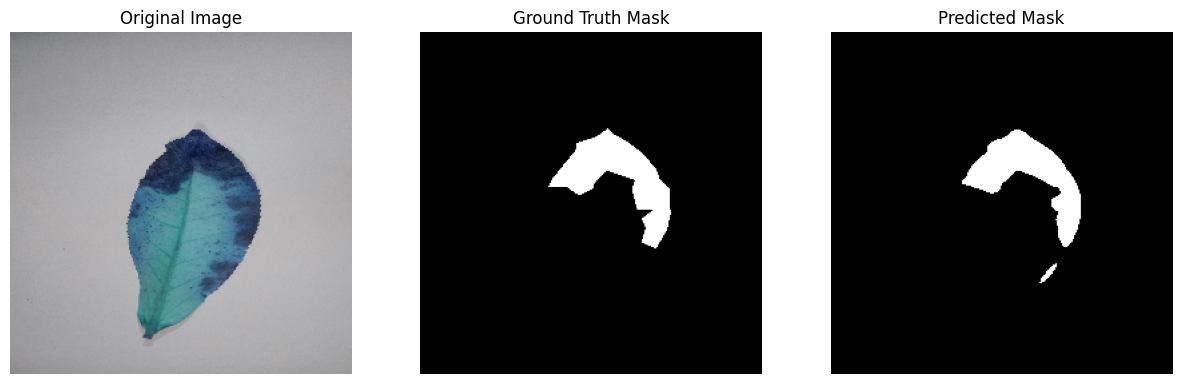

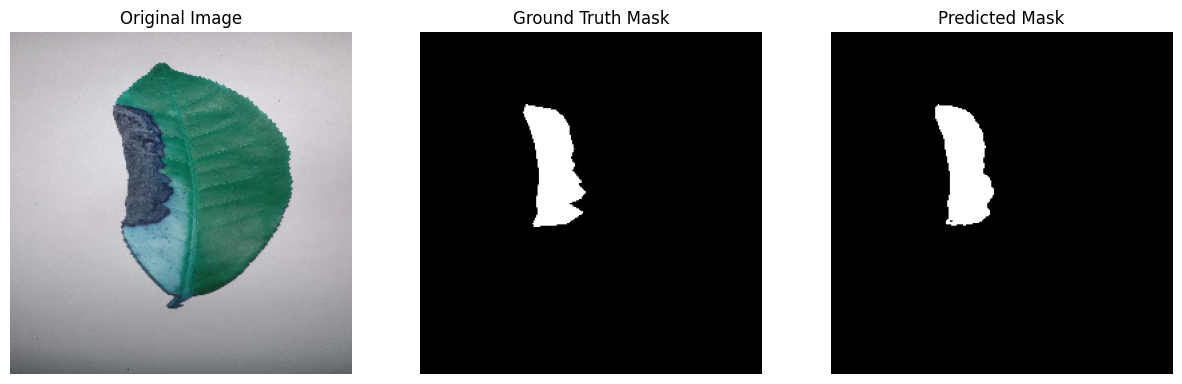

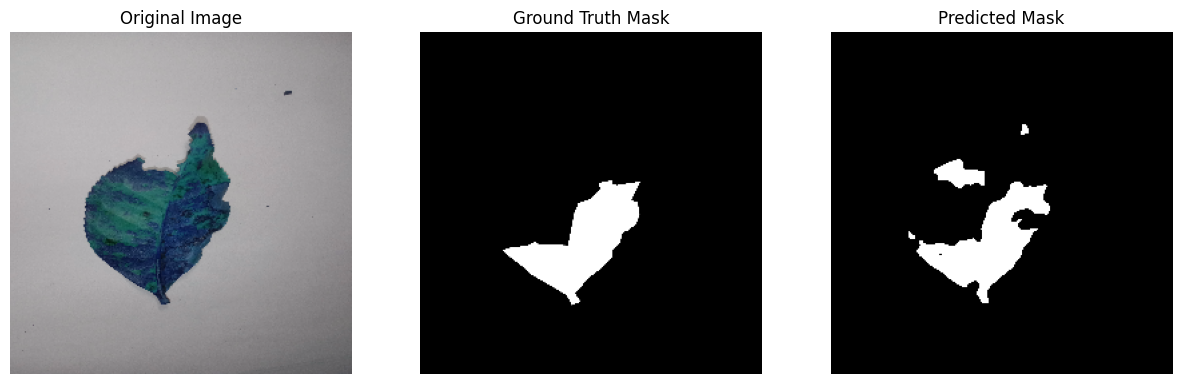

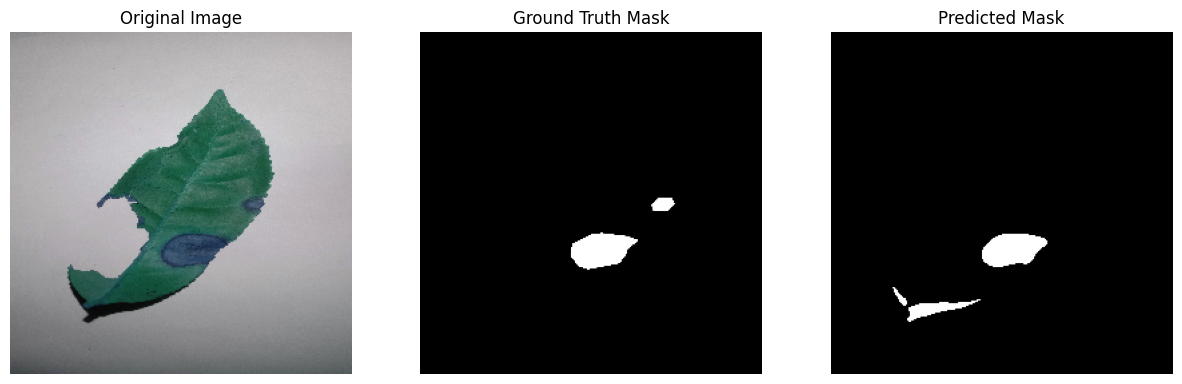

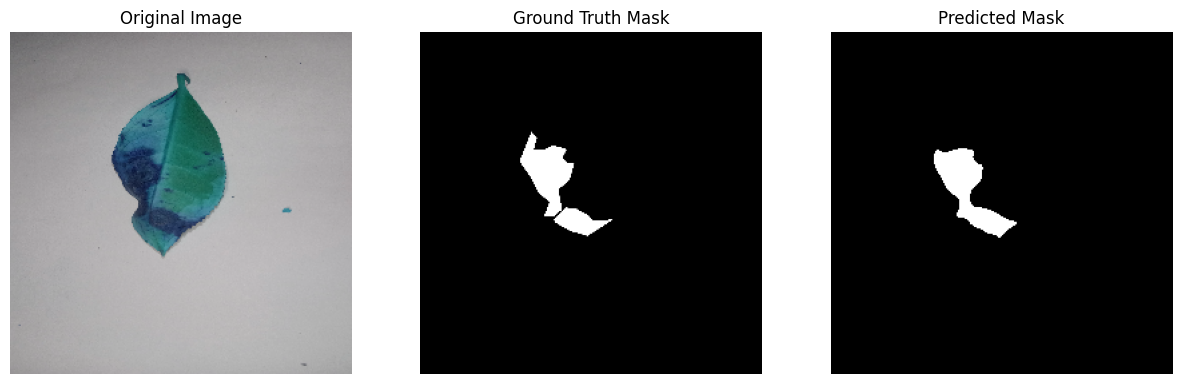

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Make predictions on the test set
predictions = unet_model.predict(X_test)

# Create masks from the predictions
predicted_masks = create_mask(predictions)

# Function to visualize the results
def visualize_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        # Original image
        img = images[i]
        # Ground truth mask
        true_mask = masks[i]
        # Predicted mask
        predicted_mask = predictions[i]
        
        # Plotting
        plt.figure(figsize=(15, 5))
        
        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

# Visualizing the results
visualize_results(X_test, y_test, predicted_masks, num_images=5)

# Optionally, you can save some of the predicted masks for further analysis
def save_predicted_masks(predictions, output_dir="predicted_masks"):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for i, pred in enumerate(predictions):
        mask_path = os.path.join(output_dir, f"pred_mask_{i}.png")
        cv2.imwrite(mask_path, (pred.squeeze() * 255).astype(np.uint8))  # Save as binary image

# Save the predicted masks
save_predicted_masks(predicted_masks)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


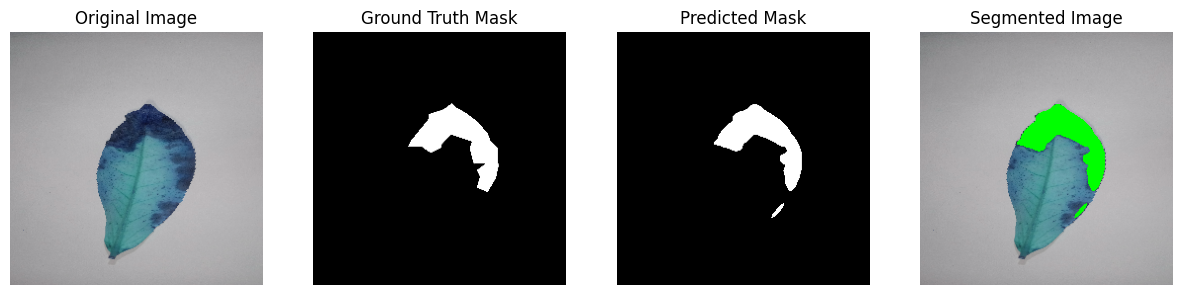

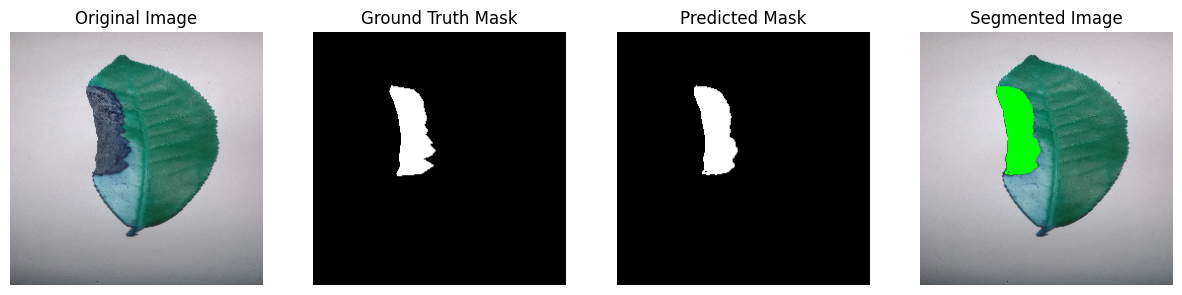

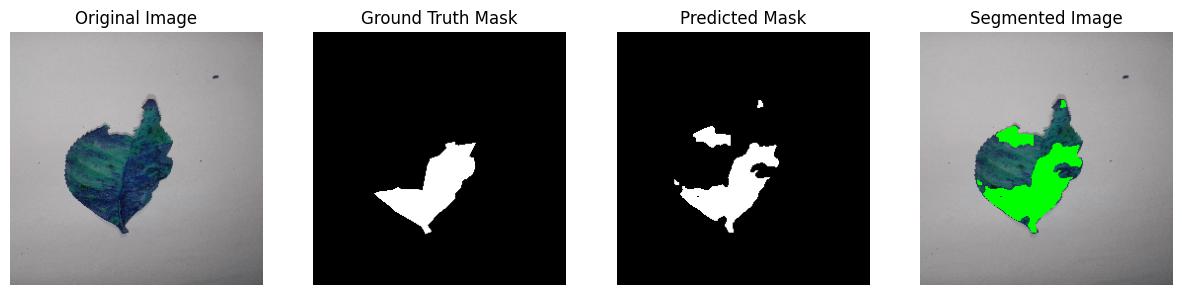

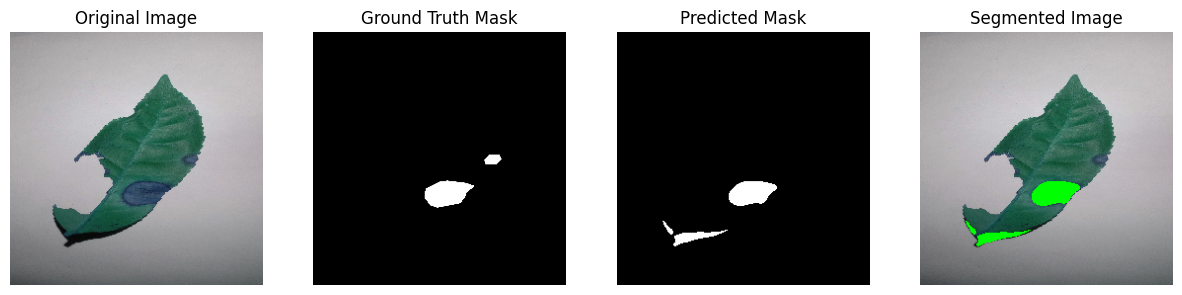

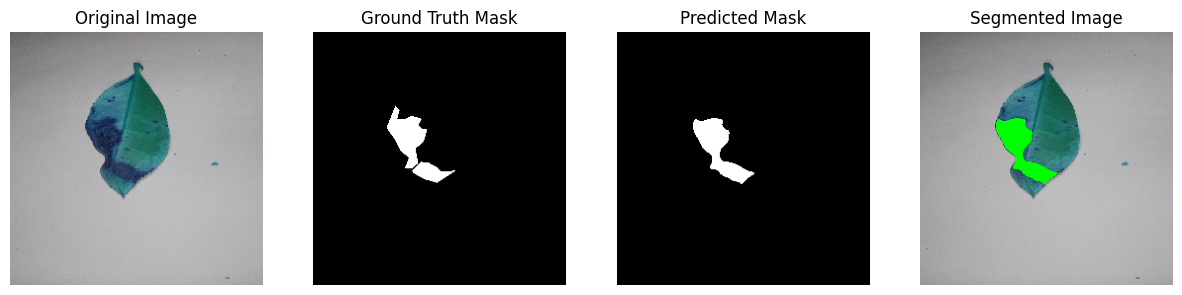

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Prediction and Mask Creation
def create_mask(predictions):
    # Convert predictions to binary mask
    predictions = (predictions > 0.5).astype(np.uint8)
    return predictions

# Make predictions on the test set
predictions = unet_model.predict(X_test)

# Create masks from the predictions
predicted_masks = create_mask(predictions)

# Function to visualize the results
def visualize_results(images, masks, predictions, num_images=5):
    for i in range(num_images):
        # Original image
        img = images[i]
        # Ground truth mask
        true_mask = masks[i]
        # Predicted mask
        predicted_mask = predictions[i]
        
        # Create the segmented image (original image + predicted mask)
        segmented_img = img.copy()
        segmented_img[predicted_mask.squeeze() == 1] = [0, 255, 0]  # Highlight segmented regions in green

        # Plotting
        plt.figure(figsize=(15, 5))
        
        # Plot original image
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(1, 4, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(1, 4, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        # Plot segmented image
        plt.subplot(1, 4, 4)
        plt.imshow(segmented_img)
        plt.title('Segmented Image')
        plt.axis('off')
        
        plt.show()

# Visualizing the results with segmented images
visualize_results(X_test, y_test, predicted_masks, num_images=5)

# Optionally, you can save some of the predicted masks for further analysis
def save_predicted_masks(predictions, output_dir="predicted_masks"):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for i, pred in enumerate(predictions):
        mask_path = os.path.join(output_dir, f"pred_mask_{i}.png")
        cv2.imwrite(mask_path, (pred.squeeze() * 255).astype(np.uint8))  # Save as binary image

# Save the predicted masks
save_predicted_masks(predicted_masks)


Mean IoU: 0.8460
Mean Dice Coefficient: 0.9125
Mean Pixel Accuracy: 0.9937


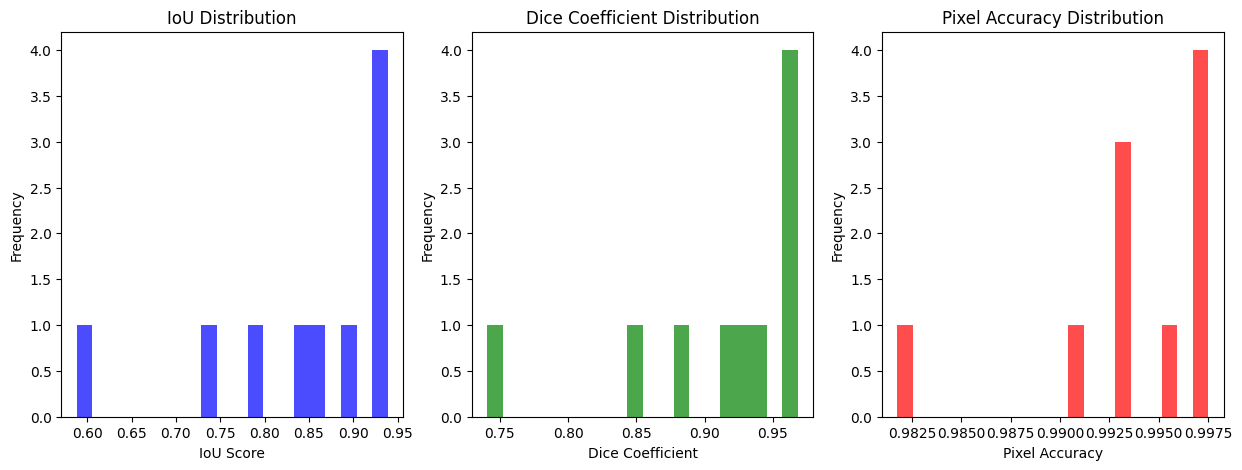

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score

def calculate_metrics(y_true, y_pred):
    """
    Calculates IoU, Dice coefficient, and pixel accuracy.
    """
    iou_scores = []
    dice_scores = []
    pixel_accuracies = []
    
    for true, pred in zip(y_true, y_pred):
        # Convert to binary (threshold at 0.5)
        true = (true > 0.5).astype(np.uint8).flatten()
        pred = (pred > 0.5).astype(np.uint8).flatten()
        
        # Compute IoU (Jaccard Index)
        iou = jaccard_score(true, pred, average='binary')
        iou_scores.append(iou)
        
        # Compute Dice Coefficient
        dice = f1_score(true, pred, average='binary')
        dice_scores.append(dice)
        
        # Compute Pixel Accuracy
        pixel_acc = np.mean(true == pred)
        pixel_accuracies.append(pixel_acc)
    
    return np.mean(iou_scores), np.mean(dice_scores), np.mean(pixel_accuracies)

# Ensure binary masks
y_test_bin = (y_test > 0.5).astype(np.uint8)
predicted_masks_bin = (predicted_masks > 0.5).astype(np.uint8)

# Compute metrics for segmentation results
iou, dice, pixel_acc = calculate_metrics(y_test_bin, predicted_masks_bin)

print(f"Mean IoU: {iou:.4f}")
print(f"Mean Dice Coefficient: {dice:.4f}")
print(f"Mean Pixel Accuracy: {pixel_acc:.4f}")

# Visualizing metric distributions
def plot_metric_distributions(y_true, y_pred):
    """
    Plots histograms for IoU, Dice coefficient, and Pixel Accuracy.
    """
    iou_scores = []
    dice_scores = []
    pixel_accuracies = []
    
    for true, pred in zip(y_true, y_pred):
        true = true.flatten()
        pred = pred.flatten()
        
        iou_scores.append(jaccard_score(true, pred, average='binary'))
        dice_scores.append(f1_score(true, pred, average='binary'))
        pixel_accuracies.append(np.mean(true == pred))
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(iou_scores, bins=20, color='blue', alpha=0.7)
    plt.xlabel("IoU Score")
    plt.ylabel("Frequency")
    plt.title("IoU Distribution")
    
    plt.subplot(1, 3, 2)
    plt.hist(dice_scores, bins=20, color='green', alpha=0.7)
    plt.xlabel("Dice Coefficient")
    plt.ylabel("Frequency")
    plt.title("Dice Coefficient Distribution")
    
    plt.subplot(1, 3, 3)
    plt.hist(pixel_accuracies, bins=20, color='red', alpha=0.7)
    plt.xlabel("Pixel Accuracy")
    plt.ylabel("Frequency")
    plt.title("Pixel Accuracy Distribution")
    
    plt.show()

# Plot metric distributions (Pass binary masks)
plot_metric_distributions(y_test_bin, predicted_masks_bin)
